In [54]:
import numpy as np
import pandas as pd

import os
import re
import json

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from wordcloud import WordCloud

from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

%matplotlib inline

# EDA

In [2]:
# 데이터 구조를 확인
DATA_IN_PATH = './quora_data/'

print('file size: ')
for file in os.listdir(DATA_IN_PATH):
    if 'csv' in file:
        print(file.ljust(30) + str(round(os.path.getsize(DATA_IN_PATH + file) / 1000000, 2)) + 'MB')

# train_data의 형태를 확인
train_data = pd.read_csv(DATA_IN_PATH + 'train.csv')
print('\n •Total number of train_data: {}'.format(len(train_data))) # 약 40만 개
train_data.head()

file size: 
test.csv                      477.59MB
train.csv                     63.4MB
sample_submission.csv         22.35MB

 •Total number of train_data: 404290


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [3]:
# 학습 데이터 (train.csv) : 63.4 MB < 평가 데이터 (test.csv) 477.59 MB
# : quora에서 직접 컴퓨터가 만든 질문 쌍을 평가 데이터에 임의적으로 추가

In [4]:
# 학습 데이터의 question1과 question2를 하나로 합침
# qusetion1(약 40만 개) + question2(약 40만 개) = 80만 개의 데이터
train_set = pd.Series(train_data['question1'].tolist() + 
                      train_data['question2'].tolist()).astype(str)
train_set.head()

0    What is the step by step guide to invest in sh...
1    What is the story of Kohinoor (Koh-i-Noor) Dia...
2    How can I increase the speed of my internet co...
3    Why am I mentally very lonely? How can I solve...
4    Which one dissolve in water quikly sugar, salt...
dtype: object

In [5]:
train_set[0]      # question1의 첫 번째 질문

'What is the step by step guide to invest in share market in india?'

In [6]:
train_set[404290] # question2의 첫 번째 질문

'What is the step by step guide to invest in share market?'

In [7]:
# 중복을 제거한 질문의 수
print("questions that eliminate duplicated question: {}".format(len(np.unique(train_set))))
print('repeated questions: {}'.format(np.sum(train_set.value_counts()>1)))

questions that eliminate duplicated question: 537361
repeated questions: 111873


Text(0, 0.5, 'Number of questions')

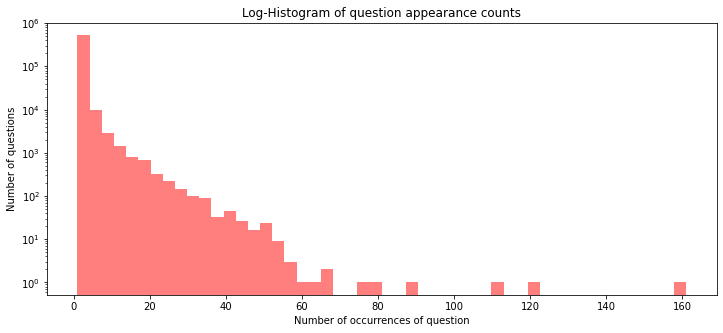

In [8]:
# 'question'의 히스토그램
plt.figure(figsize=(12, 5))
plt.hist(train_set. value_counts(), bins=50, alpha=0.5, color='r', label='word')
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurrences of question')
plt.ylabel('Number of questions')

In [9]:
# 질문의 중복 분포를 통계치로 수치화
print('중복 최대 개수: {}'.format(np.max(train_set.value_counts())))
print('중복 최소 개수: {}'.format(np.min(train_set.value_counts())))
print('중복 평균 개수: {}'.format(np.mean(train_set.value_counts())))
print('중복 표준편차: {}'.format(np.std(train_set.value_counts())))
print('중복 중간길이: {}'.format(np.median(train_set.value_counts())))
print('제1사분위 중복: {}'.format(np.percentile(train_set.value_counts(), 25)))
print('제3사분위 중복: {}'.format(np.percentile(train_set.value_counts(), 75)))

중복 최대 개수: 161
중복 최소 개수: 1
중복 평균 개수: 1.50472401234924
중복 표준편차: 1.9114373539452214
중복 중간길이: 1.0
제1사분위 중복: 1.0
제3사분위 중복: 1.0


{'whiskers': [<matplotlib.lines.Line2D at 0x7f82ec4446a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f82ec444d60>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f82ec444340>],
 'medians': [<matplotlib.lines.Line2D at 0x7f82ec45a490>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f82ec45aaf0>],
 'means': [<matplotlib.lines.Line2D at 0x7f82ec45a790>]}

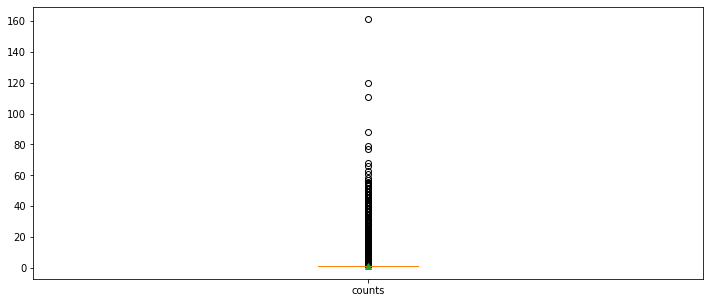

In [10]:
# 질문 중복 횟수에 대한 박스 플롯
plt.figure(figsize=(12, 5))
plt.boxplot([train_set.value_counts()],
           labels=['counts'], showmeans=True)

(-0.5, 799.5, 599.5, -0.5)

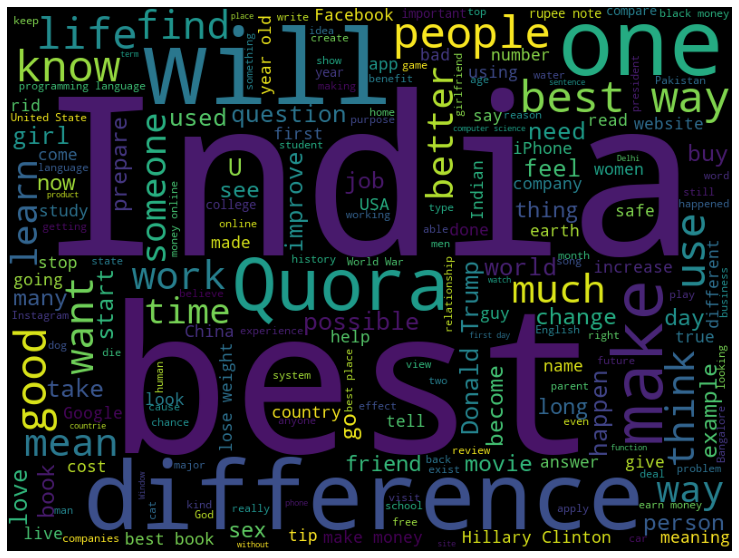

In [11]:
# wordcloud
cloud = WordCloud(width=800, height=600).generate(" ".join(train_set.astype(str)))

plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

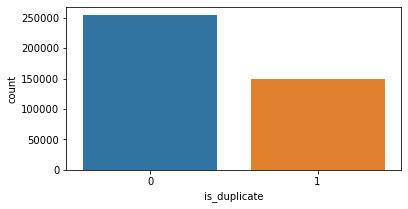

In [15]:
# label 'is_duplicate' : 질문이 중복된 경우 1, 중복되지 않은 질문인 경우 0
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(6, 3)
sns.countplot(train_data['is_duplicate'])

Text(0, 0.5, 'Probability')

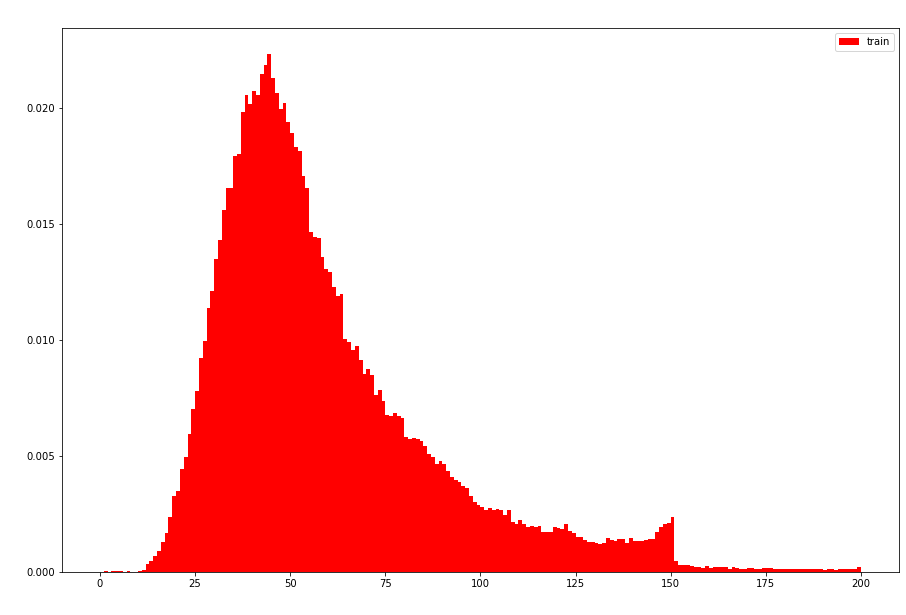

In [40]:
# 총 40만개의 질문에서 중복되지 않은 질문 : 약 25만개, 중복된 질문 : 약 15만개
# 학습을 위해 데이터의 편향성을 균형 있게 맞춰주는 것이 좋음
# 텍스트 데이터의 길이 분석 (문자 단위)
train_length = train_set.apply(len)

plt.figure(figsize=(15, 10))
plt.hist(train_length, bins=200, range=[0,200], facecolor='r', density=True, label='train')
plt.title('Normalized histogram of character count in questions', fontsize=20, color='w')
plt.legend()
plt.xlabel('Number of characters', fontsize=15, color='w')
plt.ylabel('Probability', fontsize=15, color='w')

질문 길이 최댓값: 1169
질문 길이 평균값: 59.82
질문 길이 표준편차: 31.96
질문 길이 중간값: 51.0
질문 길이 제1사분위: 39.0
질문 길이 제3사분위: 72.0


{'whiskers': [<matplotlib.lines.Line2D at 0x7f829dc934c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f829dc93b80>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f829dc93160>],
 'medians': [<matplotlib.lines.Line2D at 0x7f829dc9d280>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f829dc9d8e0>],
 'means': [<matplotlib.lines.Line2D at 0x7f829dc9d580>]}

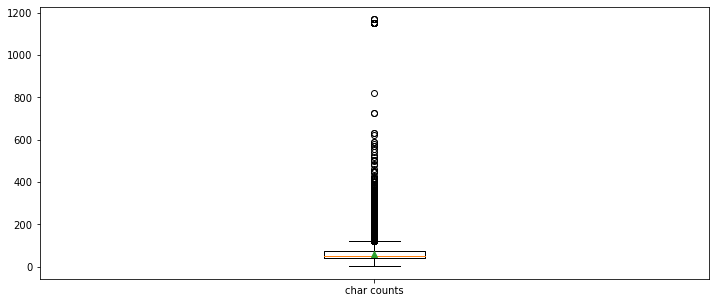

In [42]:
# 문자 단위 데이터 길이의 통계값 & 박스 플롯 그래프
print('질문 길이 최댓값: {}'.format(np.max(train_length)))
print('질문 길이 평균값: {:.2f}'.format(np.mean(train_length)))
print('질문 길이 표준편차: {:.2f}'.format(np.std(train_length)))
print('질문 길이 중간값: {}'.format(np.median(train_length)))
print('질문 길이 제1사분위: {}'.format(np.percentile(train_length, 25)))
print('질문 길이 제3사분위: {}'.format(np.percentile(train_length, 75)))

plt.figure(figsize=(12, 5))
plt.boxplot(train_length, labels=['char counts'], showmeans=True)
# 문자 수의 이상치 데이터가 너무 많이 분포

Text(0, 0.5, 'Probability')

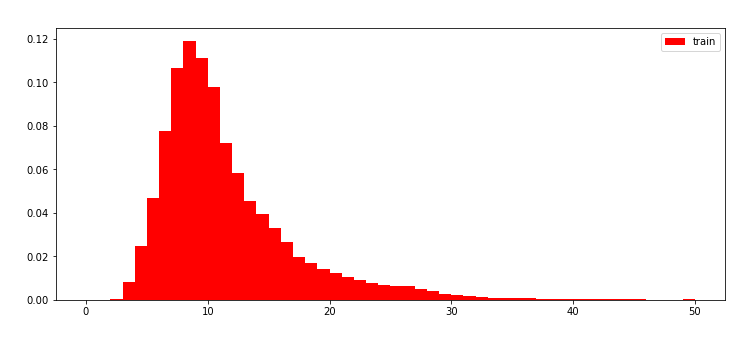

In [43]:
# 단어 개수를 하나의 단위로 데이터의 길이값 분석 (기준: 띄어쓰기)
train_word_counts = train_set.apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(12, 5))
plt.hist(train_word_counts, bins=50, range=[0, 50], facecolor='r',density=True, label='train')
plt.title('Normalized histogram of word count in questions', fontsize=20, color='w')
plt.legend()
plt.xlabel('Number of words', fontsize=15, color='w')
plt.ylabel('Probability', fontsize=15, color='w')

질문 단어 개수 최댓값: 237
질문 단어 개수 평균값: 11.06
질문 단어 개수 표준편차: 5.89
질문 단어 개수 중간값: 10.0
질문 단어 개수 제1사분위: 7.0
질문 단어 개수 제3사분위: 13.0
질문 단어 개수 99퍼센트: 31.0


{'whiskers': [<matplotlib.lines.Line2D at 0x7f82a0f7b520>,
 'caps': [<matplotlib.lines.Line2D at 0x7f82a0f7bbe0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f82a0f7b1c0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f82a0f842e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f82a0f84940>],
 'means': [<matplotlib.lines.Line2D at 0x7f82a0f845e0>]}

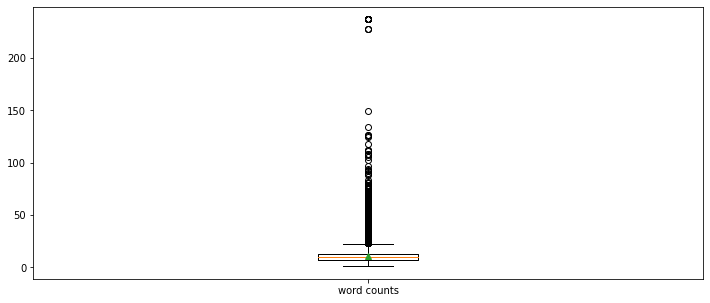

In [45]:
# 단어 단위 데이터 길이의 통계값 & 박스 플롯 그래프
print('질문 단어 개수 최댓값: {}'.format(np.max(train_word_counts)))
print('질문 단어 개수 평균값: {:.2f}'.format(np.mean(train_word_counts)))
print('질문 단어 개수 표준편차: {:.2f}'.format(np.std(train_word_counts)))
print('질문 단어 개수 중간값: {}'.format(np.median(train_word_counts)))
print('질문 단어 개수 제1사분위: {}'.format(np.percentile(train_word_counts, 25)))
print('질문 단어 개수 제3사분위: {}'.format(np.percentile(train_word_counts, 75)))
print('질문 단어 개수 99퍼센트: {}'.format(np.percentile(train_word_counts, 99)))

plt.figure(figsize=(12, 5))
plt.boxplot(train_word_counts, labels=['word counts'], showmeans=True)
# 단어 수의 이상치 데이터가 너무 많이 분포

In [49]:
# 특수문자, [], 대/소문자, 숫자의 비율을 확인
qmarks = np.mean(train_set.apply(lambda x: '?' in x)) # 물음표(?)가 구두점으로 사용
math = np.mean(train_set.apply(lambda x: '[math]' in x)) # []
fullstop = np.mean(train_set.apply(lambda x: '.' in x)) # 마침표
capital_first = np.mean(train_set.apply(lambda x: x[0].isupper())) # 첫 번째 문자가 대문자
capitals = np.mean(train_set.apply(lambda x: max([y.isupper() for y in x]))) # 대문자의 개수
numbers = np.mean(train_set.apply(lambda x: max([y.isdigit() for y in x]))) # 숫자의 개수

print('물음표가 있는 질문의 비율: {:.2f}'.format(qmarks * 100))
print('수학 태그 []가 있는 질문의 비율: {:.2f}'.format(math * 100))
print('마침표가 있는 질문의 비율: {:.2f}'.format(fullstop * 100))
print('첫 글자가 대문자인 질문의 비율: {:.2f}'.format(capital_first * 100))
print('대문자가 있는 질문의 비율: {:.2f}'.format(capitals * 100))
print('숫자가 있는 질문의 비율: {:.2f}'.format(numbers * 100))

# 질문들이 보편적으로 가지고 있는 특징은 제거

물음표가 있는 질문의 비율: 99.87
수학 태그 []가 있는 질문의 비율: 0.12
마침표가 있는 질문의 비율: 6.31
첫 글자가 대문자인 질문의 비율: 99.81
대문자가 있는 질문의 비율: 99.95
숫자가 있는 질문의 비율: 11.83
